In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Data

### Setup

In [4]:
PATH = Path('data/carvana')
list(PATH.iterdir())

[PosixPath('data/carvana/train_masks.csv'),
 PosixPath('data/carvana/train_masks_png'),
 PosixPath('data/carvana/train_masks-128'),
 PosixPath('data/carvana/metadata.csv'),
 PosixPath('data/carvana/train-128'),
 PosixPath('data/carvana/models'),
 PosixPath('data/carvana/train_masks'),
 PosixPath('data/carvana/train'),
 PosixPath('data/carvana/tmp')]

In [5]:
MASKS_FN = 'train_masks.csv'
META_FN = 'metadata.csv'
TRAIN_DN = 'train'
MASKS_DN = 'train_masks'

In [6]:
masks_csv = pd.read_csv(PATH/MASKS_FN)
masks_csv.head()

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...


In [ ]:
meta_csv = pd.read_csv(PATH/META_FN)
meta_csv.head()

In [14]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [7]:
CAR_ID = '00087a6bd4dc'

In [8]:
list((PATH/TRAIN_DN).iterdir())[:5]

[PosixPath('data/carvana/train/b58cc561e560_01.jpg'),
 PosixPath('data/carvana/train/6343156803f9_16.jpg'),
 PosixPath('data/carvana/train/d9b2ded58b72_14.jpg'),
 PosixPath('data/carvana/train/7ac210ba75a1_02.jpg'),
 PosixPath('data/carvana/train/1c5748340af8_01.jpg')]

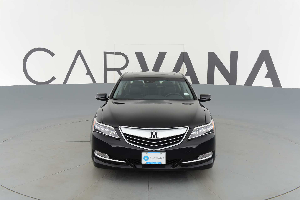

In [9]:
Image.open(PATH/TRAIN_DN/f'{CAR_ID}_01.jpg').resize((300,200))

In [10]:
list((PATH/MASKS_DN).iterdir())[:5]

[PosixPath('data/carvana/train_masks/e5fc2c1c4a8b_06_mask.gif'),
 PosixPath('data/carvana/train_masks/2a4a8964ebf3_11_mask.gif'),
 PosixPath('data/carvana/train_masks/b44091aa62e4_13_mask.gif'),
 PosixPath('data/carvana/train_masks/d1a3af34e674_10_mask.gif'),
 PosixPath('data/carvana/train_masks/245f9c9eab8a_03_mask.gif')]

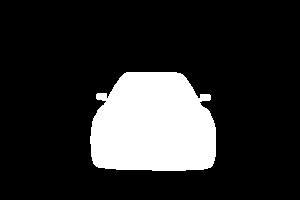

In [11]:
Image.open(PATH/MASKS_DN/f'{CAR_ID}_01_mask.gif').resize((300,200))

In [12]:
ims = [open_image(PATH/TRAIN_DN/f'{CAR_ID}_{i+1:02d}.jpg') for i in range(16)]

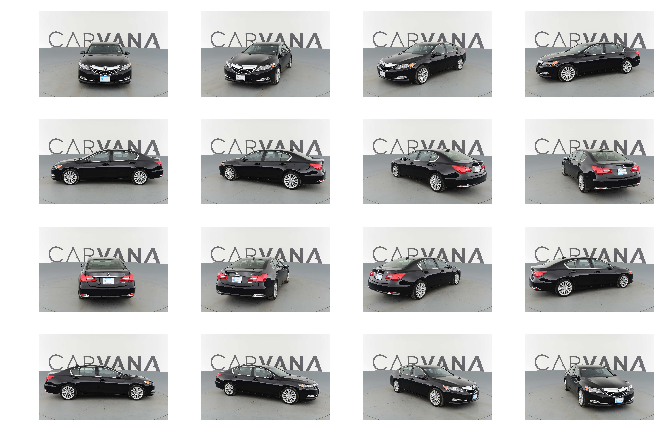

In [15]:
fig, axes = plt.subplots(4, 4, figsize=(9, 6))
for i,ax in enumerate(axes.flat): show_img(ims[i], ax=ax)
plt.tight_layout(pad=0.1)

### Resize and convert

Very large files -> need to shrink down; convert .gif into .png

In [17]:
(PATH/'train_masks_png').mkdir(exist_ok=True)

In [18]:
def convert_img(fn):
    fn = fn.name
    Image.open(PATH/'train_masks'/fn).save(PATH/'train_masks_png'/f'{fn[:-4]}.png')

In [19]:
files = list((PATH/'train_masks').iterdir())
with ThreadPoolExecutor(8) as e: e.map(convert_img, files)  # parallel processing

In [20]:
(PATH/'train_masks-128').mkdir(exist_ok=True)

In [21]:
def resize_mask(fn):
    Image.open(fn).resize((128,128)).save((fn.parent.parent)/'train_masks-128'/fn.name)

files = list((PATH/'train_masks_png').iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_mask, files)

In [22]:
(PATH/'train-128').mkdir(exist_ok=True)

In [23]:
def resize_img(fn):
    Image.open(fn).resize((128,128)).save((fn.parent.parent)/'train-128'/fn.name)

files = list((PATH/'train').iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_img, files)

## Dataset

In [16]:
TRAIN_DN = 'train-128'
MASKS_DN = 'train_masks-128'
sz = 128
bs = 64

In [25]:
ims = [open_image(PATH/TRAIN_DN/f'{CAR_ID}_{i+1:02d}.jpg') for i in range(16)]
im_masks = [open_image(PATH/MASKS_DN/f'{CAR_ID}_{i+1:02d}_mask.png') for i in range(16)]

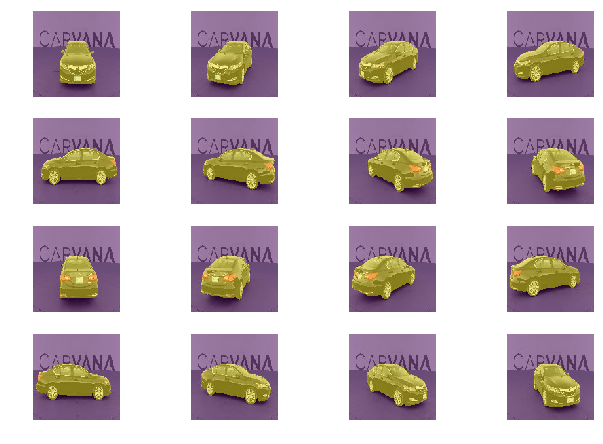

In [26]:
fig, axes = plt.subplots(4, 4, figsize=(9, 6))
for i,ax in enumerate(axes.flat):
    ax = show_img(ims[i], ax=ax)
    show_img(im_masks[i][...,0], ax=ax, alpha=0.5)
    # use same ax object to plot image and mask (w/ transparency)
plt.tight_layout(pad=0.1)

In [17]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [18]:
x_names = np.array([Path(TRAIN_DN)/o for o in masks_csv['img']])
y_names = np.array([Path(MASKS_DN)/f'{o[:-4]}_mask.png' for o in masks_csv['img']])

In [19]:
len(x_names)//16//5*16

1008

In [22]:
# use a contiguous set of car_ids instead of random to ensure that no sets of 16 are split btw train/val (cheating!)
val_idxs = list(range(1008))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)
len(val_x),len(trn_x)

(1008, 4080)

### Data Augmentation

In [23]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.CLASS),  # transform type Classification
            RandomFlip(tfm_y=TfmType.CLASS),
            RandomLighting(0.05, 0.05)]
# aug_tfms = []

In [24]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=8, classes=None)

In [25]:
denorm = md.trn_ds.denorm
x,y = next(iter(md.aug_dl))
x = denorm(x)

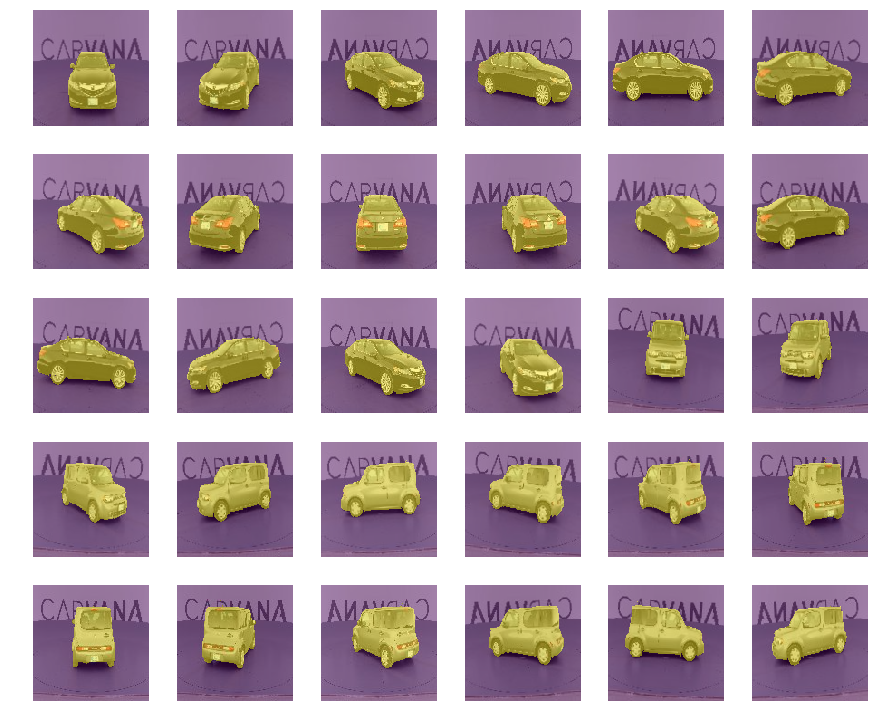

In [26]:
fig, axes = plt.subplots(5, 6, figsize=(12, 10))
for i,ax in enumerate(axes.flat):
    ax=show_img(x[i], ax=ax)
    show_img(y[i], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

## Model

In [27]:
class Empty(nn.Module): 
    def forward(self,x): return x

models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=Empty())
learn = ConvLearner(md, models)
# learn.summary()

In [28]:
class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))

In [29]:
flatten_channel = Lambda(lambda x: x[:,0])  # lambda layer -> removing unit axis

In [30]:
# bunch of upsamples 
simple_up = nn.Sequential(
    nn.ReLU(),
    StdUpsample(512,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    nn.ConvTranspose2d(256, 1, 2, stride=2),  #=> (bs, 1, 128, 128)
    flatten_channel  # we want (bs, 128, 128)
)

In [31]:
# dice metric: similar to jaccard (I over U)
def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()  # intersection over union w/ minor tweak

# metric used in the kaggle comp.

In [61]:
models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=simple_up)  # resnet34 downsamples, custom head upsamples
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5), dice]

In [62]:
# freeze to n layer_group
# lets start training only the last layer (simple_up)
learn.freeze_to(-1)

 89%|████████▉ | 57/64 [00:07<00:00,  7.63it/s, loss=1]    


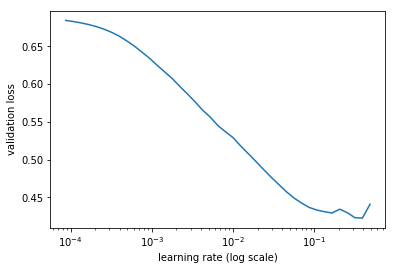

In [42]:
learn.lr_find()
learn.sched.plot()

In [45]:
lr=4e-2

In [63]:
learn.fit(lr,1,cycle_len=5,use_clr=(20,5))

epoch      trn_loss   val_loss   <lambda>   dice            
    0      0.093656   0.161173   0.9404     0.849273  
    1      0.092358   0.095072   0.957245   0.900925        
    2      0.084839   0.094252   0.960611   0.905934        
    3      0.078852   0.085465   0.960926   0.91018         
    4      0.074031   0.079054   0.964735   0.918178        



[0.07905373840578019, 0.9647352430555556, 0.9181775971064492]

In [77]:
learn.save('tmp')

In [47]:
learn.load('tmp')

In [78]:
py,ay = learn.predict_with_targs()

In [79]:
ay.shape

(1008, 128, 128)

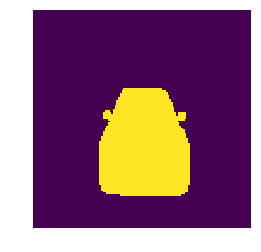

In [80]:
show_img(ay[0]);

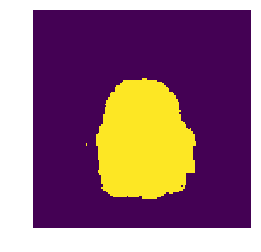

In [82]:
show_img(py[0]>0);

**looks like 96% accuracy isn't very good!!**

In [64]:
learn.unfreeze()

In [65]:
learn.bn_freeze(True)

In [66]:
lrs = np.array([lr/100,lr/10,lr])/2

In [67]:
learn.fit(lrs,1,cycle_len=10,use_clr=(20,10))

epoch      trn_loss   val_loss   <lambda>   dice            
    0      0.093455   0.05503    0.978196   0.944138  
    1      0.054021   0.039031   0.983026   0.960208        
    2      0.039978   0.033689   0.984977   0.96582         
    3      0.035434   0.031013   0.986258   0.969206        
    4      0.030527   0.029727   0.988235   0.970754        
    5      0.027536   0.027993   0.987601   0.972401        
    6      0.02529    0.025977   0.989085   0.974714        
    7      0.023792   0.025641   0.988768   0.974929        
    8      0.022656   0.024171   0.990131   0.976707        
    9      0.021638   0.023553   0.990408   0.977556        



[0.023552923951120602, 0.990408216203962, 0.9775561463265192]

In [68]:
learn.save('128_0.977')

In [88]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

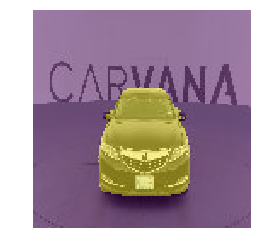

In [89]:
ax = show_img(denorm(x)[0])
show_img(py[0]>0, ax=ax, alpha=0.5);

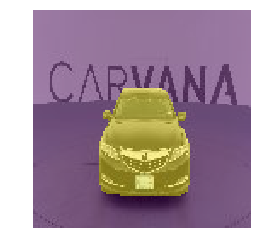

In [90]:
ax = show_img(denorm(x)[0])
show_img(y[0], ax=ax, alpha=0.5);

**still not quite good enough.  missing the side view mirrors.  edges not perfect**

## 512x512

** upscale! **

In [34]:
TRAIN_DN = 'train'
MASKS_DN = 'train_masks_png'
sz = 512
bs = 16  # need to decrease the bs!

In [35]:
x_names = np.array([Path(TRAIN_DN)/o for o in masks_csv['img']])
y_names = np.array([Path(MASKS_DN)/f'{o[:-4]}_mask.png' for o in masks_csv['img']])

In [36]:
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)
len(val_x),len(trn_x)

(1008, 4080)

In [37]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=8, classes=None)

In [38]:
denorm = md.trn_ds.denorm
x,y = next(iter(md.aug_dl))
x = denorm(x)

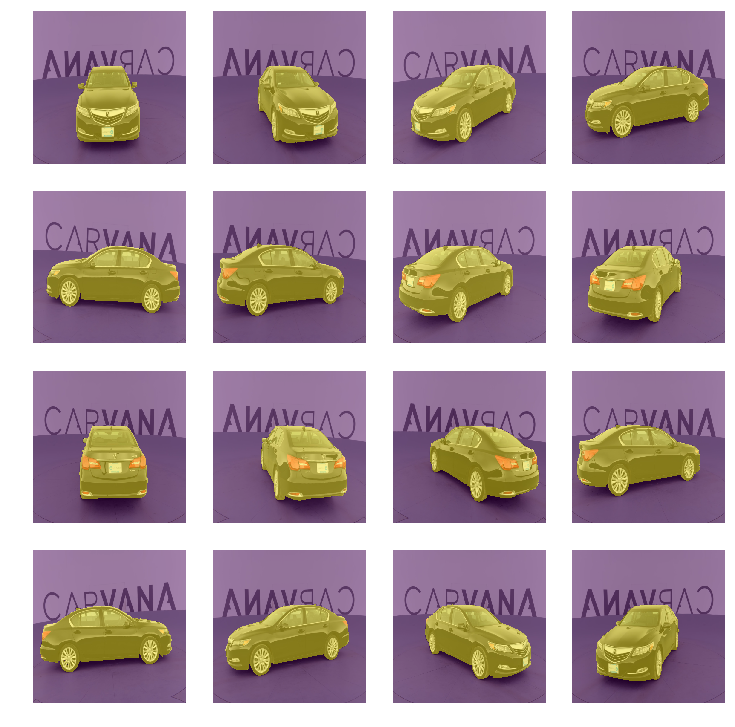

In [39]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    ax=show_img(x[i], ax=ax)
    show_img(y[i], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

In [40]:
# same as above
simple_up = nn.Sequential(
    nn.ReLU(),
    StdUpsample(512,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    nn.ConvTranspose2d(256, 1, 2, stride=2),
    flatten_channel
)

In [41]:
models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=simple_up)
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5), dice]

In [42]:
learn.load('128_0.977')

 78%|███████▊  | 198/255 [03:34<01:01,  1.08s/it, loss=0.361]

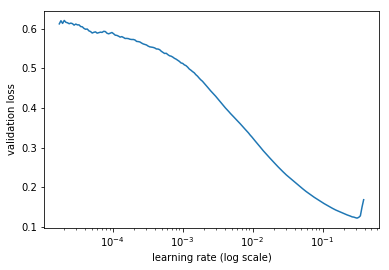

In [43]:
learn.lr_find()
learn.sched.plot(n_skip_end=1)

In [45]:
lr=1e-2

In [81]:
learn.freeze_to(-1)

In [82]:
learn.fit(lr,1,cycle_len=5,use_clr=(20,5))

epoch      trn_loss   val_loss   <lambda>   dice              
    0      0.059243   0.033667   0.985463   0.969059  
    1      0.028434   0.02362    0.99007    0.97778           
    2      0.022232   0.021052   0.991498   0.980192          
    3      0.019922   0.019958   0.992011   0.981213          
    4      0.01872    0.018761   0.992311   0.982255          


[0.01876108082277434, 0.9923109402732243, 0.982254527864002]

In [83]:
learn.save('tmp')

In [46]:
learn.load('tmp')

In [47]:
learn.unfreeze()
learn.bn_freeze(True)

In [48]:
lrs = np.array([lr/100,lr/10,lr])/2

In [49]:
learn.fit(lrs,1,cycle_len=10,use_clr=(20,10))

epoch      trn_loss   val_loss   <lambda>   dice              
    0      0.013005   0.012047   0.995179   0.988802  
    1      0.010062   0.009982   0.995877   0.990622          
    2      0.008878   0.009347   0.995945   0.991098           
    3      0.008168   0.008805   0.996278   0.991682           
    4      0.007595   0.008497   0.996335   0.991899           
    5      0.00734    0.008161   0.996743   0.992231           
    6      0.006999   0.007865   0.996762   0.992602           
    7      0.006642   0.007568   0.996869   0.992836           
    8      0.006401   0.007534   0.996914   0.992979           
    9      0.006211   0.007311   0.997033   0.993127           


[0.007310970996816953, 0.9970329791780502, 0.9931270366623288]

In [50]:
learn.save('512')

In [51]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

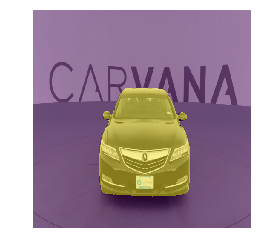

In [54]:
ax = show_img(denorm(x)[0])
show_img(py[0]>0, ax=ax, alpha=0.5);

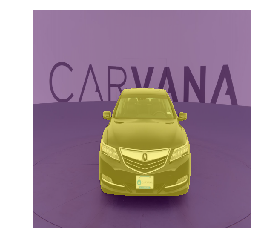

In [53]:
ax = show_img(denorm(x)[0])
show_img(y[0], ax=ax, alpha=0.5);

## 1024x1024

In [55]:
sz = 1024
bs = 4

In [56]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=8, classes=None)

In [25]:
denorm = md.trn_ds.denorm
x,y = next(iter(md.aug_dl))
x = denorm(x)
y = to_np(y)

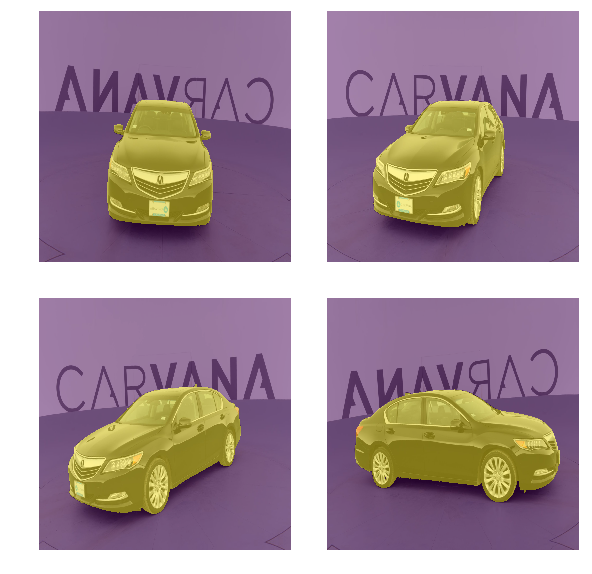

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for i,ax in enumerate(axes.flat):
    show_img(x[i], ax=ax)
    show_img(y[i], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

In [57]:
simple_up = nn.Sequential(
    nn.ReLU(),
    StdUpsample(512,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    nn.ConvTranspose2d(256, 1, 2, stride=2),
    flatten_channel,
)

In [58]:
models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=simple_up)
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5), dice]

In [59]:
learn.load('512')

 71%|███████   | 723/1020 [06:09<02:31,  1.96it/s, loss=0.0402]

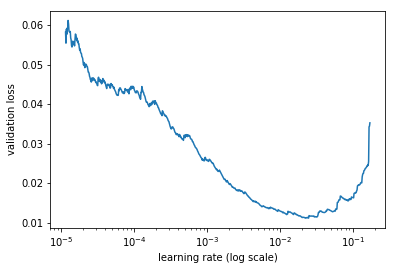

In [60]:
learn.lr_find()
learn.sched.plot(n_skip_end=1)

In [61]:
learn.freeze_to(-1)

In [62]:
lr=2e-3
# lr=4e-2

In [63]:
learn.fit(lr,1,cycle_len=4,use_clr=(20,4))

epoch      trn_loss   val_loss   <lambda>   dice                 
    0      0.008576   0.008326   0.996953   0.992948  
    1      0.007137   0.007302   0.997253   0.993686             
    2      0.006763   0.007139   0.997251   0.993802             
    3      0.006188   0.007008   0.997321   0.99392              


[0.007007587599449806, 0.9973211307374258, 0.9939201556973987]

In [64]:
learn.save('tmp')

In [97]:
learn.load('tmp')

In [65]:
learn.unfreeze()
learn.bn_freeze(True)

In [66]:
lrs = np.array([lr/100,lr/10,lr])/4

In [67]:
learn.fit(lrs,1,cycle_len=8,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice                 
    0      0.006339   0.006787   0.997461   0.994154  
    1      0.005235   0.006132   0.997662   0.99472              
    2      0.005032   0.00547    0.997817   0.995007             
    3      0.004937   0.005264   0.997902   0.995116             
    4      0.004658   0.005185   0.997941   0.99524              
    5      0.004455   0.005089   0.997921   0.99529              
    6      0.004436   0.005056   0.997961   0.995328             
    7      0.004343   0.004996   0.998011   0.9954               


[0.004996408280613463, 0.9980111557339865, 0.9953995425076712]

In [68]:
learn.save('1024')

In [71]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [77]:
py[0][0].shape

(1024,)

In [75]:
denorm(x)[0].shape

(1024, 1024, 3)

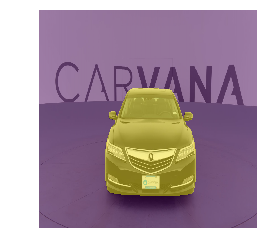

In [78]:
ax = show_img(denorm(x)[0])
show_img(py[0]>0, ax=ax, alpha=0.5);

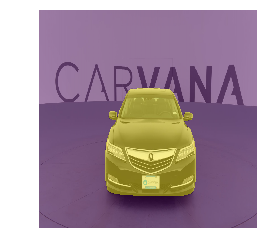

In [80]:
ax = show_img(denorm(x)[0])
show_img(y[0], ax=ax, alpha=0.5);

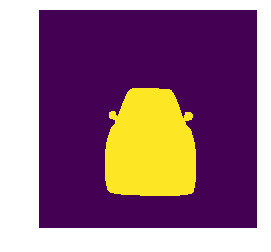

In [81]:
show_img(py[0]>0);

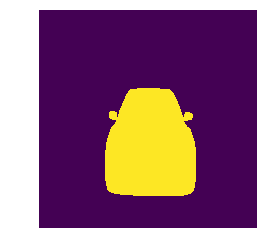

In [82]:
show_img(y[0]);

## Fin

Looks pretty good but we can do better!  Carvana-unet!